# Adding Classifier Predictions to a Dataset

This recipe provides a glimpse into the possibilities for integrating FiftyOne into your ML workflows. Specifically, it covers:

- [Loading](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html) an image classification dataset in FiftyOne
- Adding classifier predictions to a dataset
- Launching the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html) and visualizing/exploring your data
- Integrating the App into your data analysis workflow

## Setup

If you haven't already, install FiftyOne:

In [ ]:
!pip install fiftyone

You'll also need to install `torch` and `torchvision`, if necessary:

In [1]:
!pip install torch torchvision

In this example, we'll work with the test split of the CIFAR-10 dataset, which is conveniently available for download from the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/datasets.html#dataset-zoo-cifar10):

In [2]:
# Downloads the test split of CIFAR-10
!fiftyone zoo datasets download cifar10 --splits test

170500096it [00:05, 30536650.39it/s]                                            
Extracting /Users/Brian/fiftyone/cifar10/tmp-download/cifar-10-python.tar.gz to /Users/Brian/fiftyone/cifar10/tmp-download
 100% |███| 10000/10000 [5.7s elapsed, 0s remaining, 1.9K samples/s]      
Dataset info written to '/Users/Brian/fiftyone/cifar10/info.json'


We'll also download a pre-trained CIFAR-10 PyTorch model that we'll use to generate some predictions:

In [1]:
# Download the software
!git clone --depth 1 --branch v2.1 https://github.com/huyvnphan/PyTorch_CIFAR10.git

# Download the pretrained model (90MB)
!eta gdrive download --public \
    1dGfpeFK_QG0kV-U6QDHMX2EOGXPqaNzu \
    PyTorch_CIFAR10/cifar10_models/state_dicts/resnet50.pt

Cloning into 'PyTorch_CIFAR10'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 82 (delta 13), reused 59 (delta 12), pack-reused 0
Unpacking objects: 100% (82/82), done.
Note: checking out '2a2e76a56f943b70403796387d968704e74971ae'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

 100% |████|  719.8Mb/719.8Mb [2.7s elapsed, 0s remaining, 276.2Mb/s]      


## Loading an image classification dataset

Suppose you have an image classification dataset on disk in the following
format:

```
<dataset_dir>/
    data/
        <uuid1>.<ext>
        <uuid2>.<ext>
        ...
    labels.json
```

where `labels.json` is a JSON file in the following format:

```
{
    "classes": [
        <labelA>,
        <labelB>,
        ...
    ],
    "labels": {
        <uuid1>: <target1>,
        <uuid2>: <target2>,
        ...
    }
}
```

In your current workflow, you may parse this data into a list of `(image_path, label)` tuples as follows:

In [2]:
import json
import os

# The location of the dataset on disk that you downloaded above
dataset_dir = os.path.expanduser("~/fiftyone/cifar10/test")

# Maps image UUIDs to image paths
images_dir = os.path.join(dataset_dir, "data")
image_uuids_to_paths = {
    os.path.splitext(n)[0]: os.path.join(images_dir, n)
    for n in os.listdir(images_dir)
}

labels_path = os.path.join(dataset_dir, "labels.json")
with open(labels_path, "rt") as f:
    _labels = json.load(f)

# Get classes
classes = _labels["classes"]

# Maps image UUIDs to int targets
labels = _labels["labels"]

# Make a list of (image_path, label) samples
data = [(image_uuids_to_paths[u], classes[t]) for u, t in labels.items()]

# Print a few data
for sample in data[:5]:
    print(sample)

('/Users/Brian/fiftyone/cifar10/test/data/000001.jpg', 'cat')
('/Users/Brian/fiftyone/cifar10/test/data/000002.jpg', 'ship')
('/Users/Brian/fiftyone/cifar10/test/data/000003.jpg', 'ship')
('/Users/Brian/fiftyone/cifar10/test/data/000004.jpg', 'airplane')
('/Users/Brian/fiftyone/cifar10/test/data/000005.jpg', 'frog')


Building a [FiftyOne dataset](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html) from your samples in this format is simple:

In [3]:
import fiftyone as fo

# Load the data into FiftyOne samples
samples = []
for image_path, label in data:
    samples.append(
        fo.Sample(
            filepath=image_path,
            ground_truth=fo.Classification(label=label),
        )
    )

# Add the samples to a dataset
dataset = fo.Dataset("classifier-recipe")
dataset.add_samples(samples)

# Print some information about the dataset
print(dataset)

 100% |███████████████████| 10000/10000 [44.9s elapsed, 0s remaining, 221.4 samples/s]      
Name:           classifier-recipe
Media type:     image
Num samples:    10000
Persistent:     False
Info:           {}
Tags:           []
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


In [4]:
# Print a sample from the dataset
print(dataset.first())

<Sample: {
    'id': '603031c01ec865586e477d8e',
    'media_type': 'image',
    'filepath': '/Users/Brian/fiftyone/cifar10/test/data/000001.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '603031bf1ec865586e47567d',
        'label': 'cat',
        'confidence': None,
        'logits': None,
    }>,
}>


## Working with views

FiftyOne provides a powerful notion of [dataset views](https://voxel51.com/docs/fiftyone/user_guide/using_views.html) that you can use to explore subsets of the samples in your dataset.

Here's an example operation:

In [5]:
# Used to write view expressions that involve sample fields
from fiftyone import ViewField as F

# Gets five airplanes from the dataset
view = (
    dataset.match(F("ground_truth.label") == "airplane")
    .limit(5)
)

# Print some information about the view you created
print(view)

Dataset:        classifier-recipe
Media type:     image
Num samples:    5
Tags:           []
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
View stages:
    1. Match(filter={'$expr': {'$eq': [...]}})
    2. Limit(limit=5)


In [6]:
# Print a sample from the view
print(view.first())

<SampleView: {
    'id': '603031c01ec865586e477d94',
    'media_type': 'image',
    'filepath': '/Users/Brian/fiftyone/cifar10/test/data/000004.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '603031bf1ec865586e475680',
        'label': 'airplane',
        'confidence': None,
        'logits': None,
    }>,
}>


Iterating over the samples in a view is easy:

In [7]:
for sample in view:
    print(sample.filepath)

/Users/Brian/fiftyone/cifar10/test/data/000004.jpg
/Users/Brian/fiftyone/cifar10/test/data/000011.jpg
/Users/Brian/fiftyone/cifar10/test/data/000022.jpg
/Users/Brian/fiftyone/cifar10/test/data/000028.jpg
/Users/Brian/fiftyone/cifar10/test/data/000045.jpg


## Adding model predictions

Now let's add the predictions from our classifier to our FiftyOne dataset in a new `predictions` field:

In [8]:
import sys

import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader

import fiftyone.utils.torch as fout

sys.path.insert(1, "PyTorch_CIFAR10")
from cifar10_models import resnet50


def make_cifar10_data_loader(image_paths, sample_ids, batch_size):
    mean = [0.4914, 0.4822, 0.4465]
    std = [0.2023, 0.1994, 0.2010]
    transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean, std),
        ]
    )
    dataset = fout.TorchImageDataset(
        image_paths, sample_ids=sample_ids, transform=transforms
    )
    return DataLoader(dataset, batch_size=batch_size, num_workers=4)


def predict(model, imgs):
    logits = model(imgs).detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)
    odds = np.exp(logits)
    confidences = np.max(odds, axis=1) / np.sum(odds, axis=1)
    return predictions, confidences


#
# Load model
#
# Model performance numbers are available at:
#   https://github.com/huyvnphan/PyTorch_CIFAR10
#

model = resnet50(pretrained=True)

#
# Extract a few images to process
#

num_samples = 25
batch_size = 5

view = dataset.take(num_samples, seed=51)

image_paths, sample_ids = zip(*[(s.filepath, s.id) for s in view])
data_loader = make_cifar10_data_loader(image_paths, sample_ids, batch_size)

#
# Perform prediction and store results in dataset
#

with fo.ProgressBar() as pb:
    for imgs, sample_ids in pb(data_loader):
        predictions, confidences = predict(model, imgs)

        # Add predictions to your FiftyOne dataset
        for sample_id, prediction, confidence in zip(
            sample_ids, predictions, confidences
        ):
            sample = dataset[sample_id]
            sample["predictions"] = fo.Classification(
                label=classes[prediction],
                confidence=confidence,
            )
            sample.save()

 100% |███████████████████████████| 5/5 [1.4s elapsed, 0s remaining, 3.6 batches/s]         


We can print our dataset to verify that a `predictions` field has been added to its schema:

In [8]:
print(dataset)

Name:           classifier-recipe
Media type:     image
Num samples:    10000
Persistent:     False
Info:           {}
Tags:           []
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    predictions:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


Let's explore the predictions we added by creating a view that sorts the samples in order of prediction confidence:

In [15]:
pred_view = (
    dataset
    .exists("predictions")
    .sort_by("predictions.confidence", reverse=True)
)

print("Number of samples with predictions: %s\n" % len(pred_view))
print("Highest confidence prediction:\n")
print(pred_view.first())

Number of samples with predictions: 25

Highest confidence prediction:

<SampleView: {
    'id': '602fe4dcb6fdaf68aad0cd8c',
    'media_type': 'image',
    'filepath': '/Users/Brian/fiftyone/cifar10/test/data/005771.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '602fe4c0b6fdaf68aad08ff1',
        'label': 'ship',
        'confidence': None,
        'logits': None,
    }>,
    'predictions': <Classification: {
        'id': '602fe4feb6fdaf68aad0eed7',
        'label': 'ship',
        'confidence': 0.8228137493133545,
        'logits': None,
    }>,
}>


## Using the FiftyOne App

FiftyOne provides a [powerful App](https://voxel51.com/docs/fiftyone/user_guide/app.html) that allows you easily visualize, explore, search, filter, your datasets.

You can explore the App interactively through the GUI, and you can even interact with it in real-time from your Python interpreter!


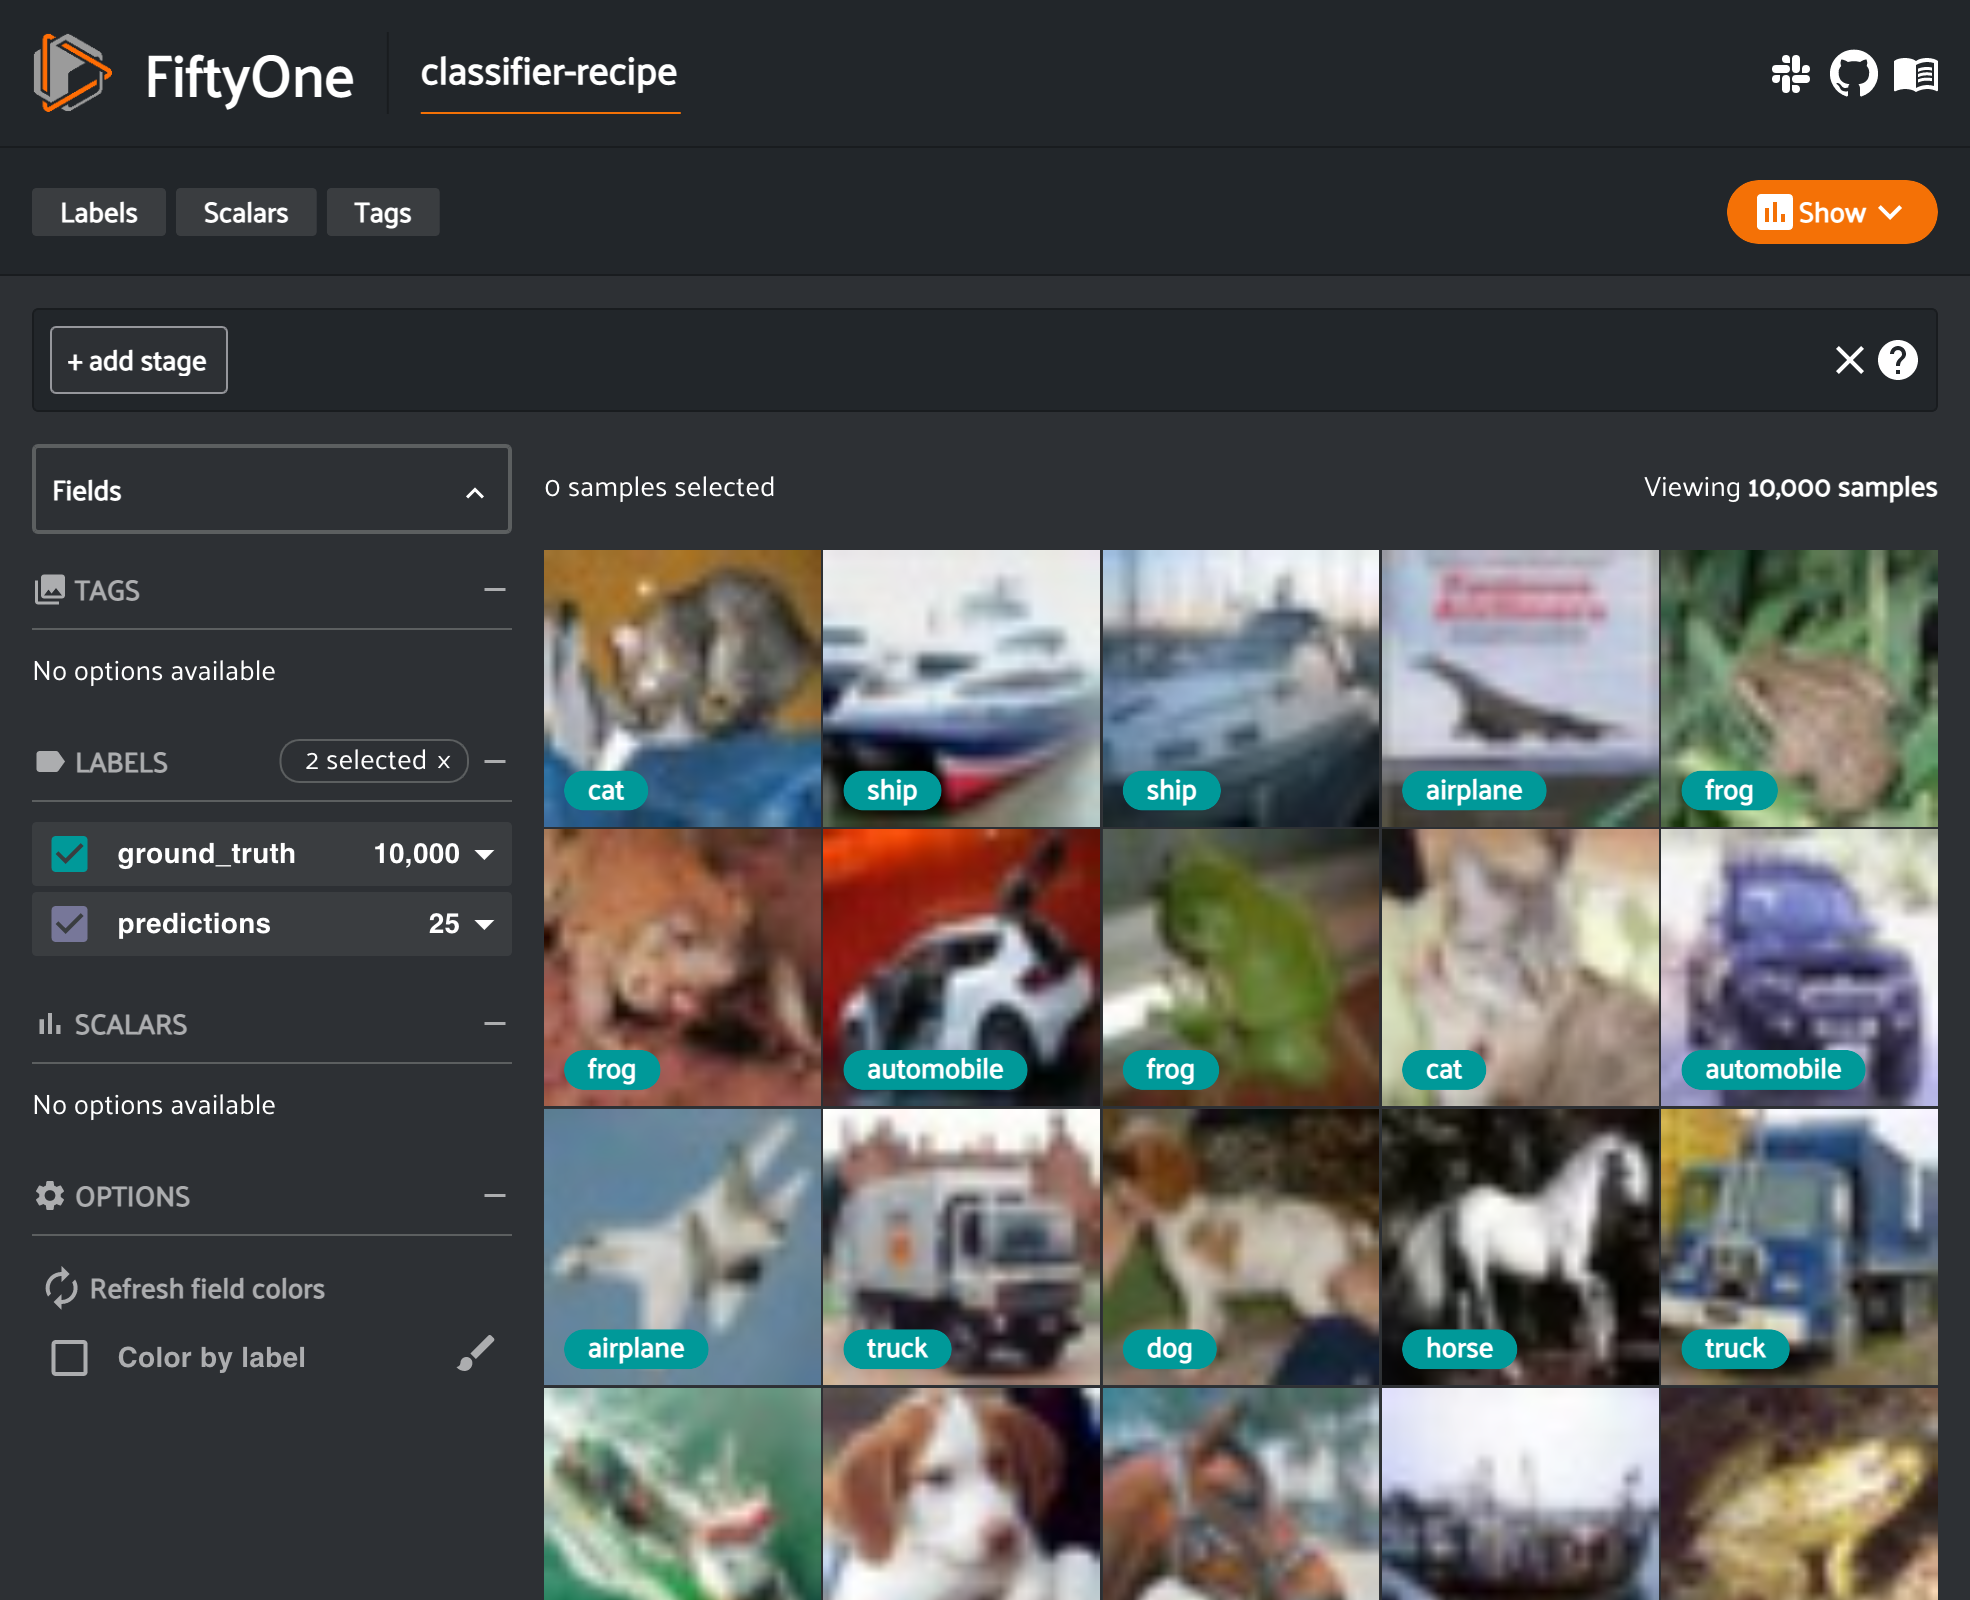

In [16]:
# Open the dataset in the App
session = fo.launch_app(dataset)


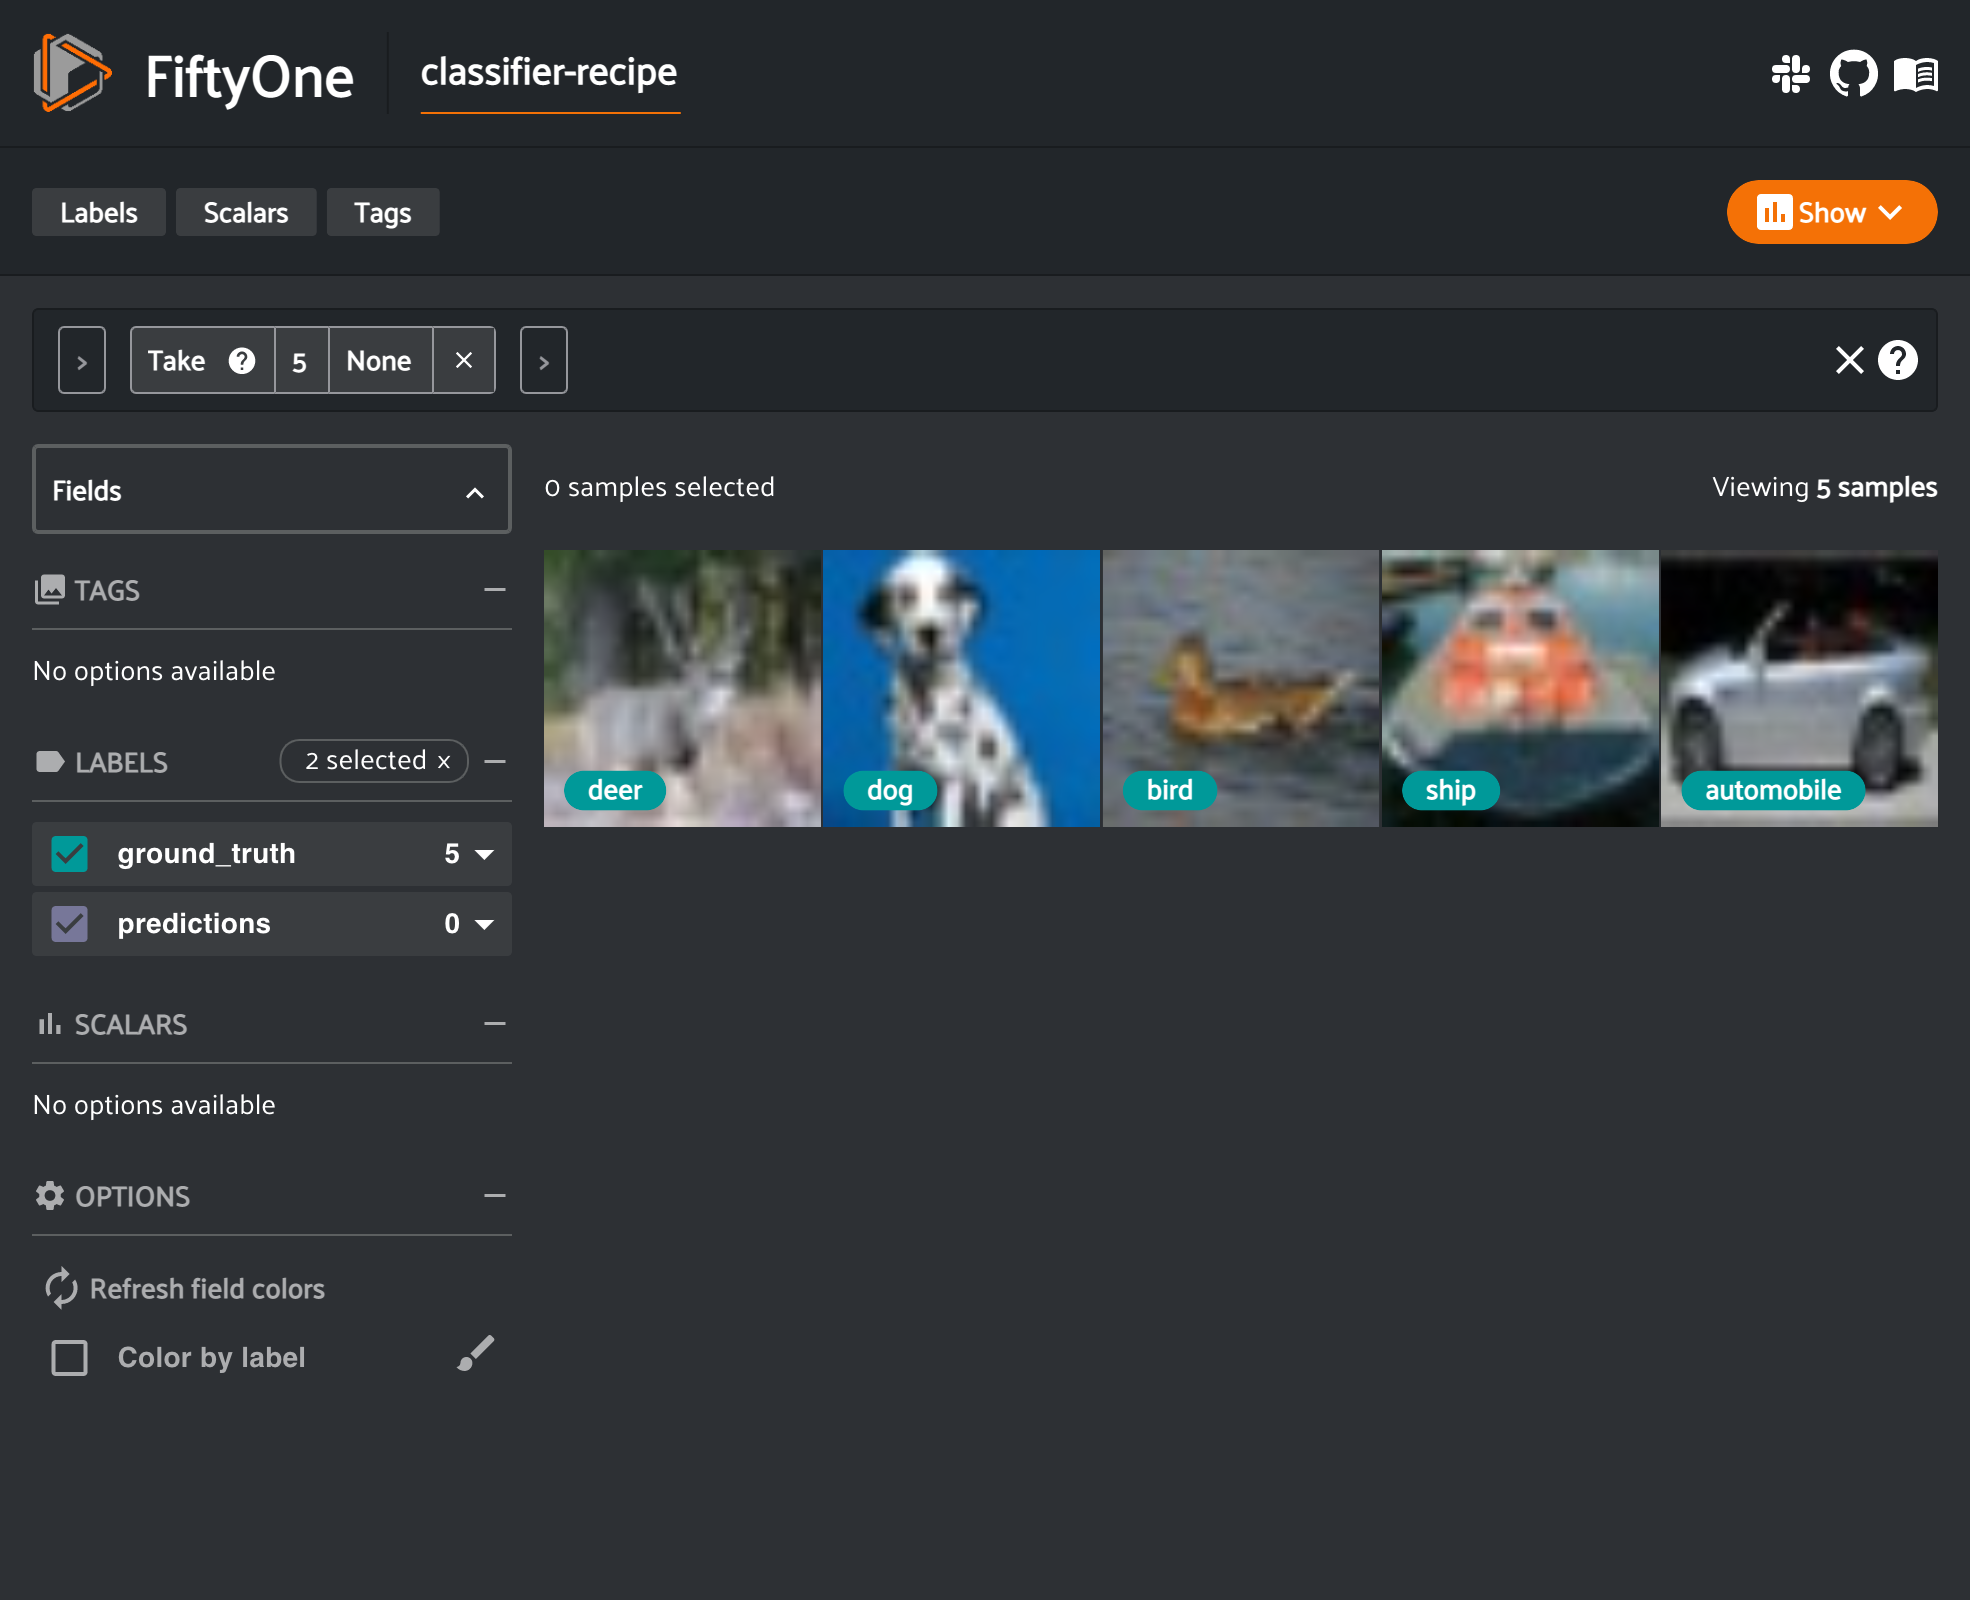

In [17]:
# Show five random samples in the App
session.view = dataset.take(5)


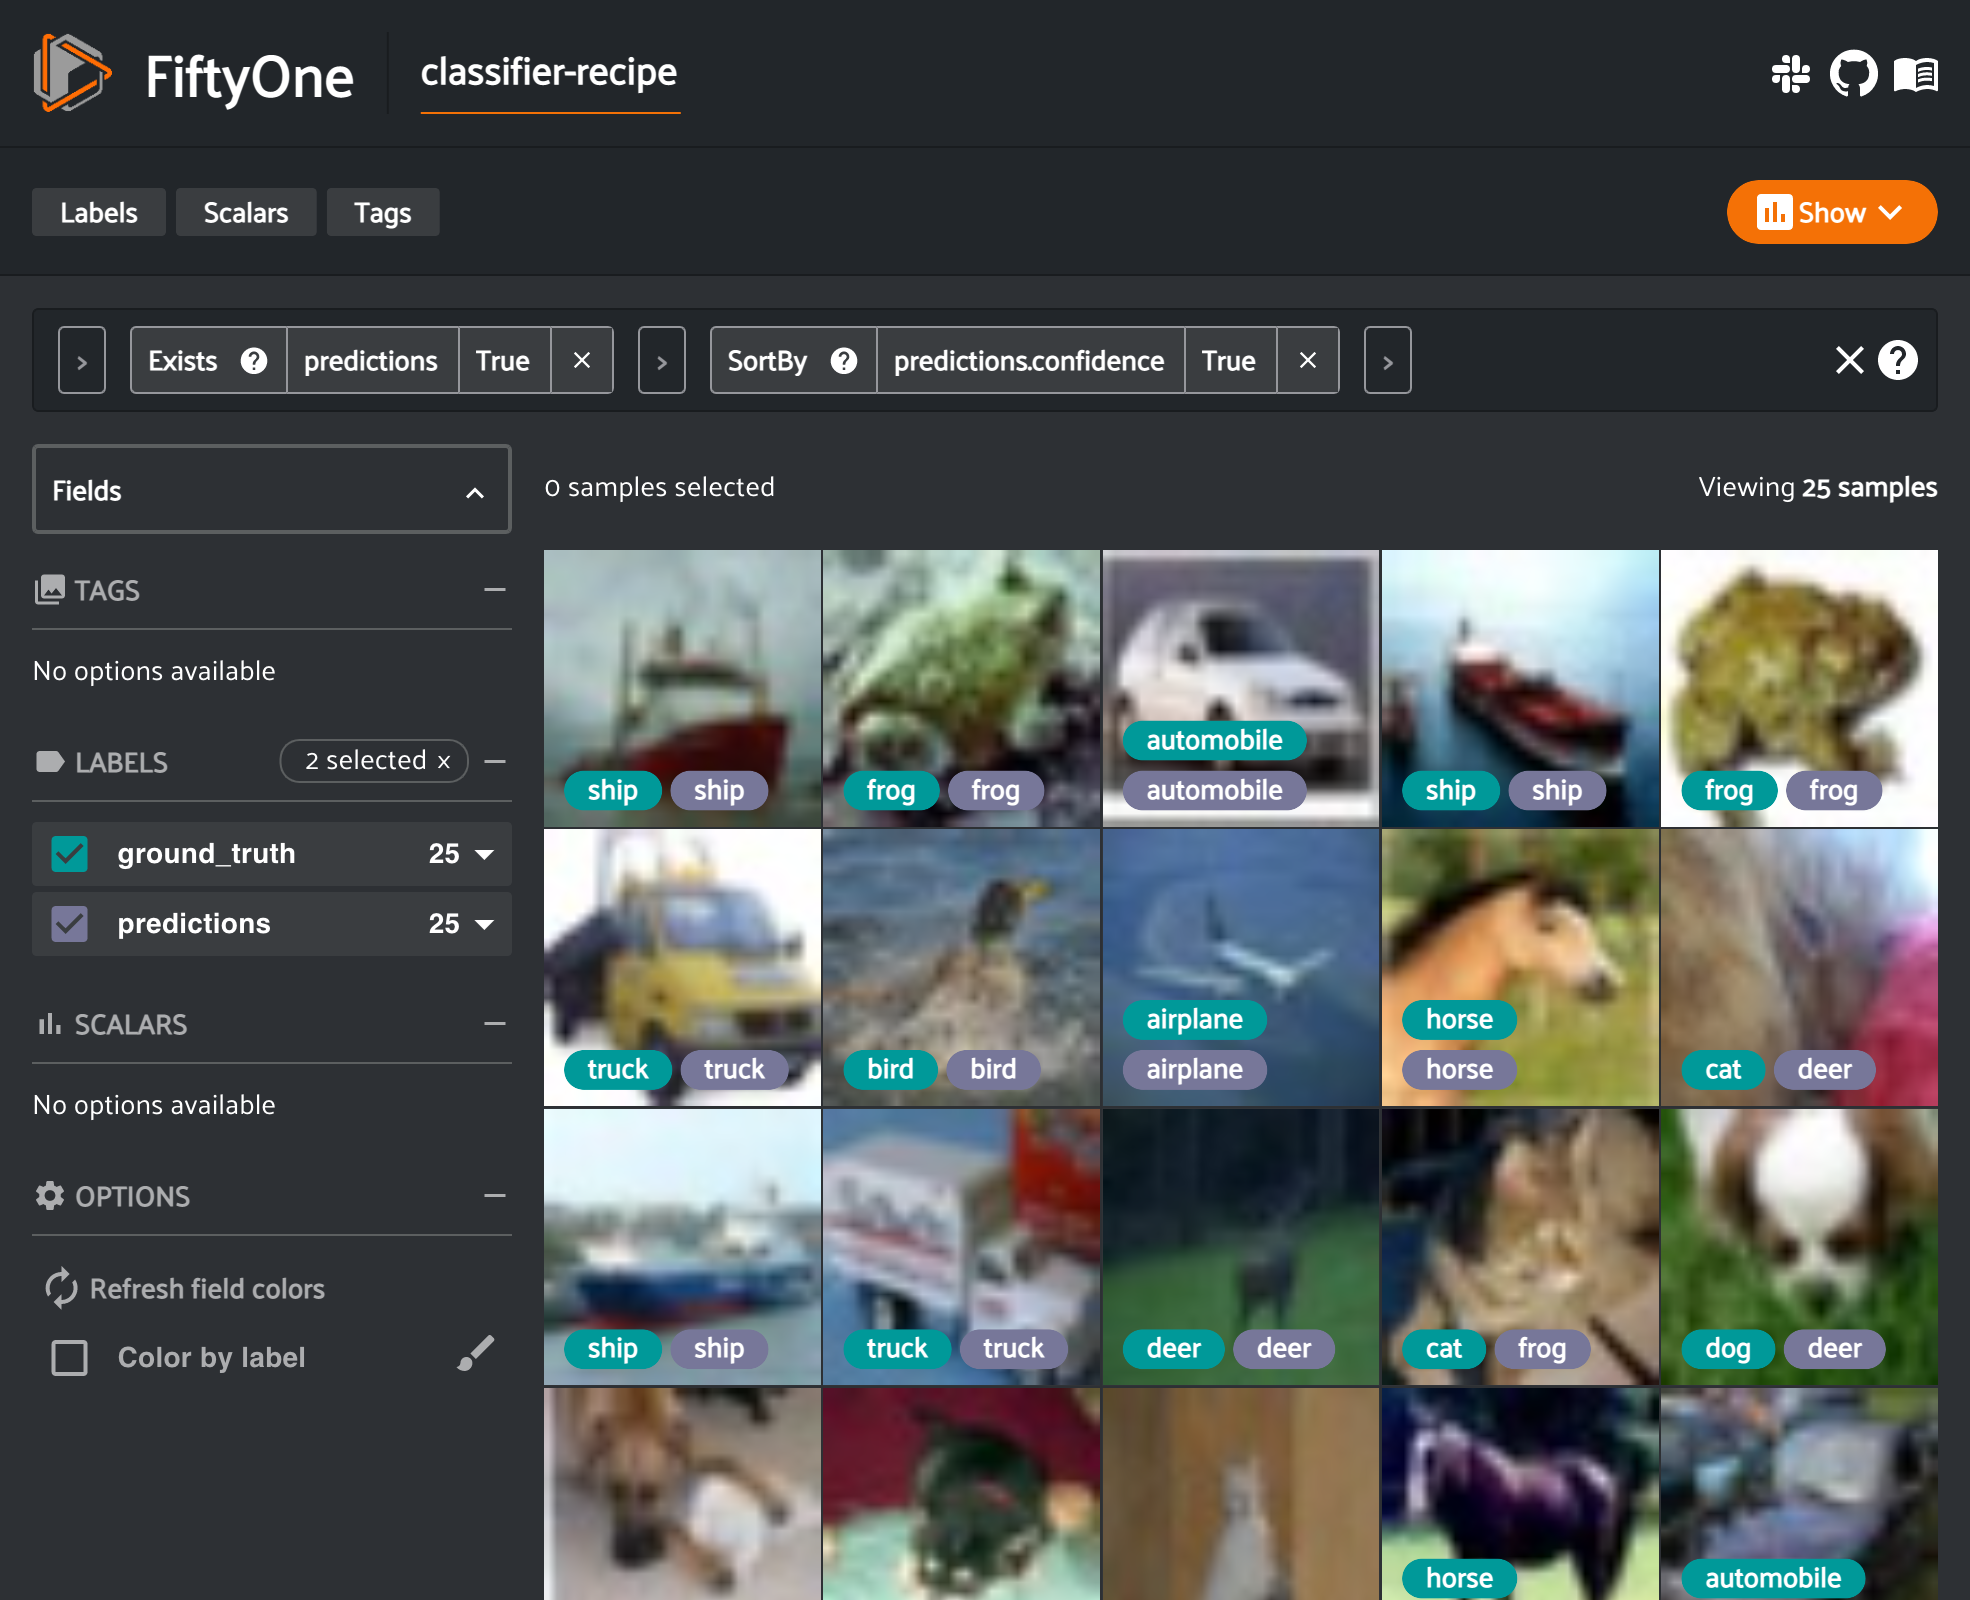

In [18]:
# Show the samples for which we added predictions above
session.view = pred_view


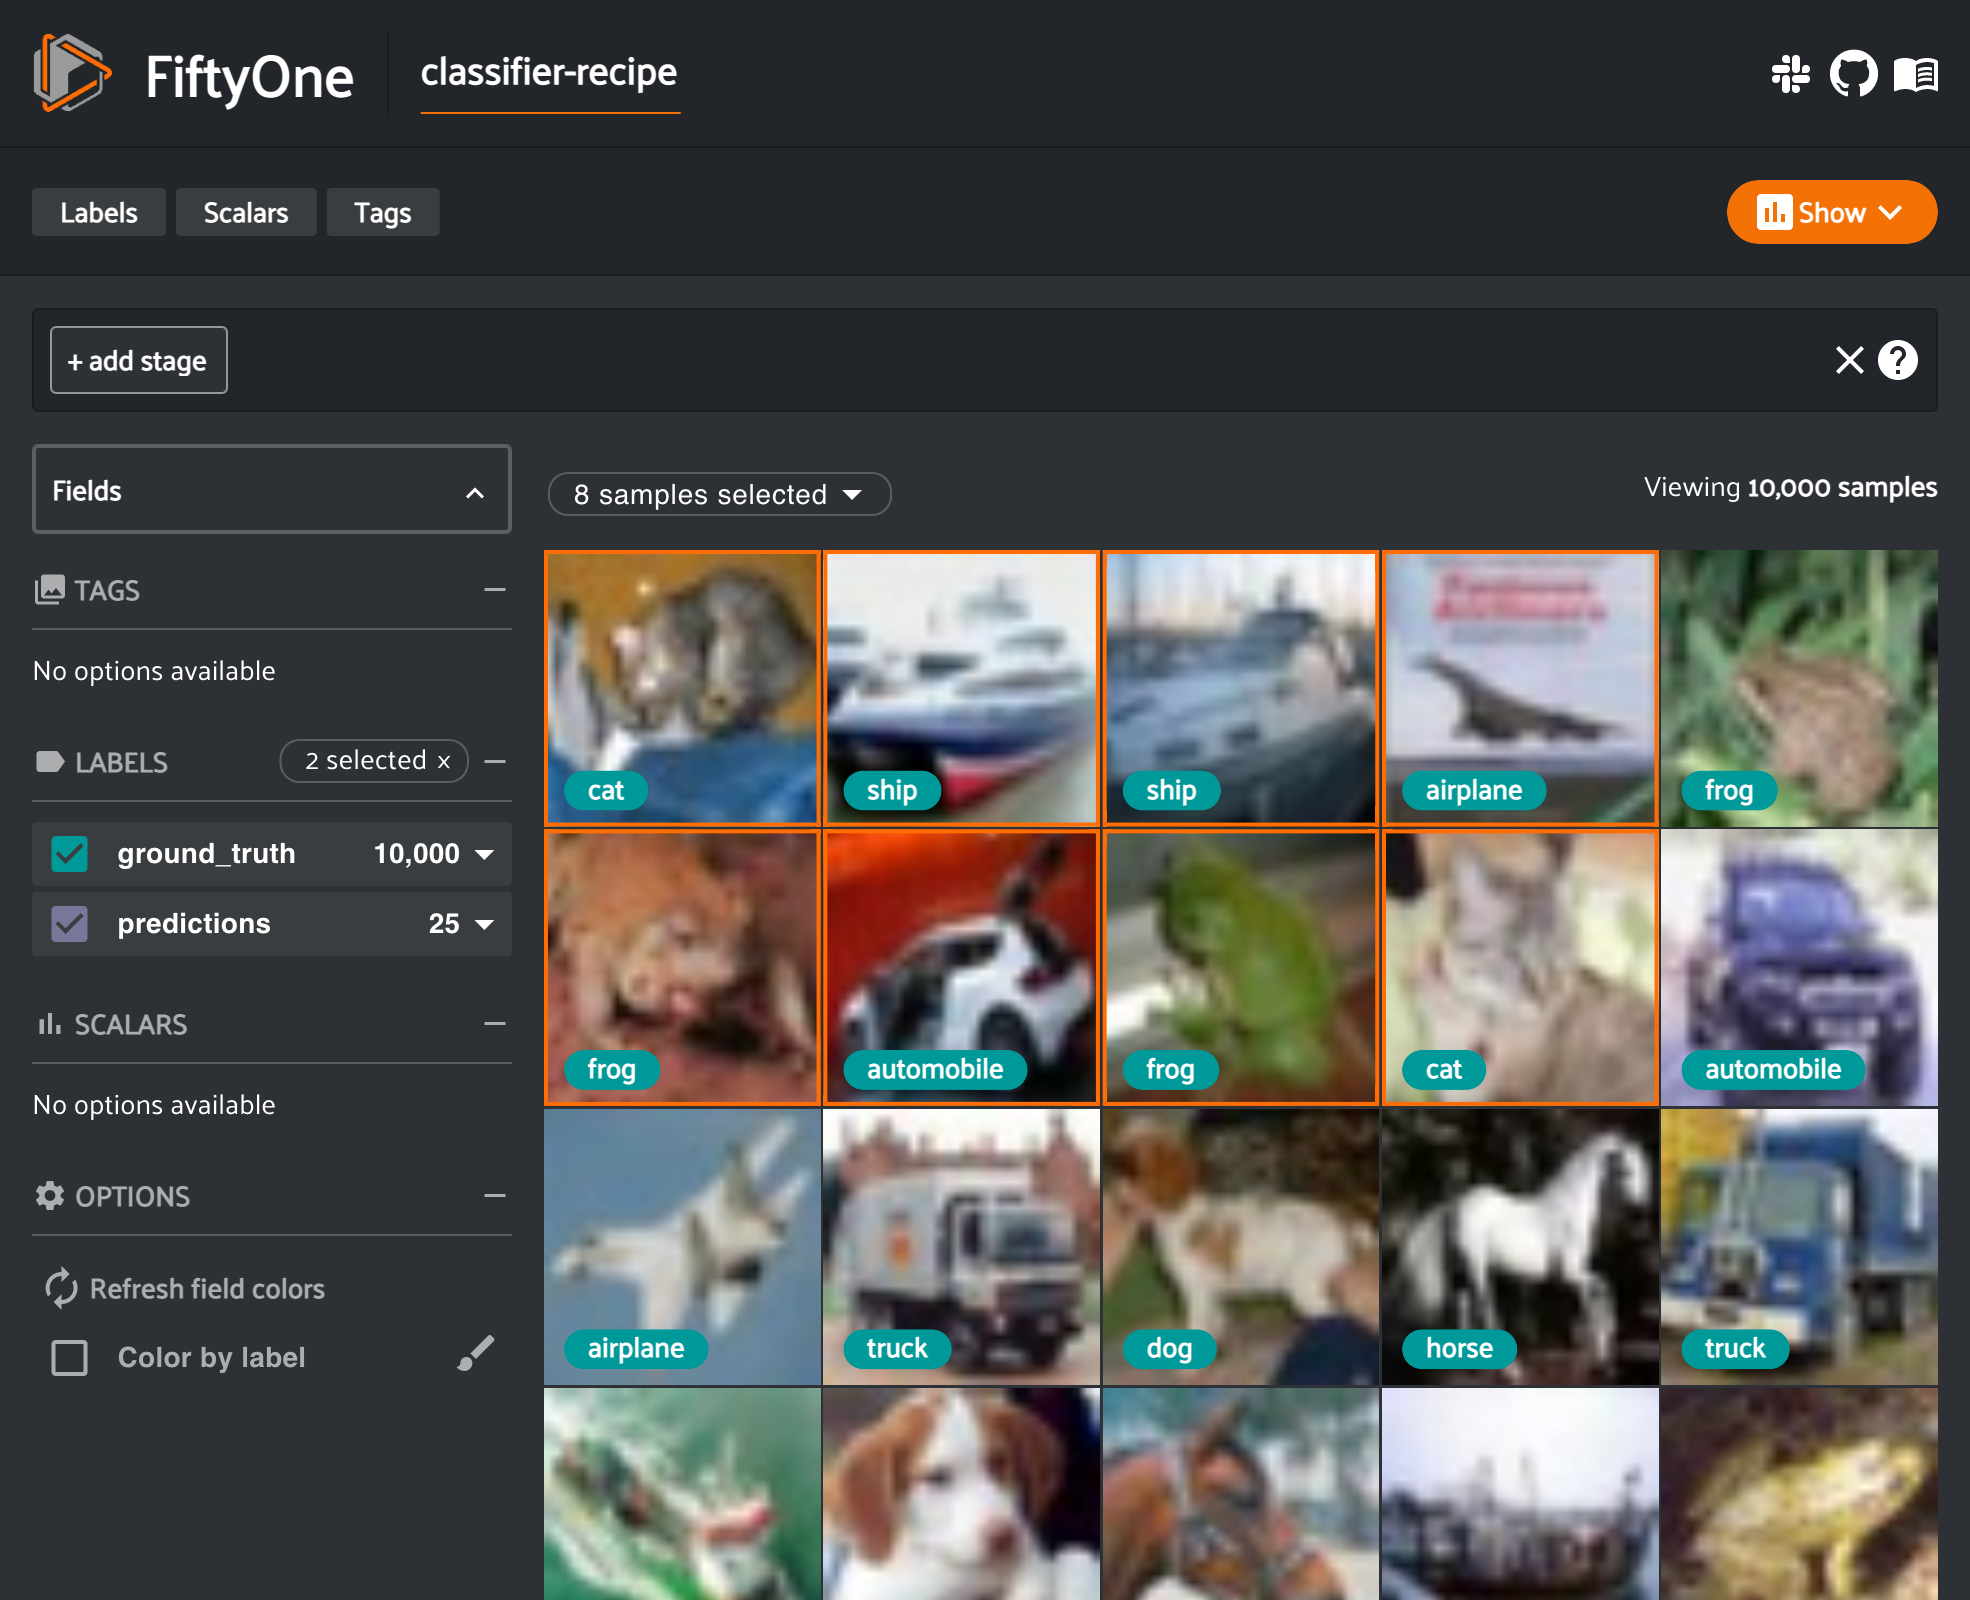

In [19]:
# Show the full dataset again
session.view = None

You can select samples in the App by clicking on the images. Try it!

After you've selected some images in the App, you can hop back over to Python and make a view that contains those samples!

In [20]:
# Make a view containing the currently selected samples in the App
selected_view = dataset.select(session.selected)

# Print details about the selected samples
print(selected_view)

Dataset:        classifier-recipe
Media type:     image
Num samples:    8
Tags:           []
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    predictions:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
View stages:
    1. Select(sample_ids=['602fe4c1b6fdaf68aad0a07a', '602fe4c1b6fdaf68aad0a082', '602fe4c1b6fdaf68aad0a086', ...])


In [21]:
session.freeze() # screenshot the active App for sharing